<a href="https://colab.research.google.com/github/skj092/monocular-depth-estimation/blob/main/mde_pt_keras_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq pytorch_msssim
!pip install -qq python-dotenv
!git clone https://github.com/skj092/monocular-depth-estimation.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00


In [31]:
import sys
sys.path.append('monocular-depth-estimation/src/mde/')
import pandas as pd
import numpy as np
import cv2
import os
import torch
from sklearn.model_selection import train_test_split
import wandb
from dotenv import load_dotenv
from loss_fns import calculate_loss, CombinedDepthLoss
from model2 import DepthEstimationModel
import keras
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from engine import train_epoch, validate_epoch
from fastai.vision.all import *

In [32]:
from google.colab import userdata
os.environ['WANDB_API_KEY'] = userdata.get('wandb')

In [33]:
wandb.login(key=os.getenv("WANDB_API_KEY"))
wandb.init(project="DepthEstimation", name="PyTorch-Training",)

# load_dotenv()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: skj092 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
# # Data Download
# annotation_folder = "/dataset/"
# if not os.path.exists(os.path.abspath(".") + annotation_folder):
#     annotation_zip = keras.utils.get_file(
#         "val.tar.gz",
#         cache_subdir=os.path.abspath("."),
#         origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
#         extract=True,
#     )

In [37]:
# data loading and preprocessing
train_path = "val_extracted/val/indoors"
filelist = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()

images = sorted([x for x in filelist if x.endswith(".png")])
depths = sorted([x for x in filelist if x.endswith("_depth.npy")])
masks = sorted([x for x in filelist if x.endswith("_depth_mask.npy")])

# Get base names
depth_bases = {os.path.basename(x).replace("_depth.npy", "") for x in depths}
mask_bases = {os.path.basename(x).replace("_depth_mask.npy", "") for x in masks}
valid_bases = depth_bases & mask_bases

# Filter valid files only
valid_images = [x for x in images if os.path.basename(x).replace(".png", "") in valid_bases]
valid_depths = [x for x in depths if os.path.basename(x).replace("_depth.npy", "") in valid_bases]
valid_masks = [x for x in masks if os.path.basename(x).replace("_depth_mask.npy", "") in valid_bases]

# Build DataFrame
data = {
    "image": valid_images,
    "depth": valid_depths,
    "mask": valid_masks,
}
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Total train samples: {len(df)}")
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(valid_df)}")

Total train samples: 325
Training samples: 260, Validation samples: 65


In [38]:
# Dataset and DataLoader setup
def open_image(fn):
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    return torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

def load_depth_masked(row):
    depth = np.load(row['depth']).squeeze()
    mask = np.load(row['mask']) > 0
    epsilon = 1e-6
    max_depth = min(300, np.percentile(depth[mask], 99))
    depth = np.clip(depth, epsilon, max_depth)
    depth_log = np.zeros_like(depth)
    depth_log[mask] = np.log(depth[mask])
    depth_log = np.clip(depth_log, np.log(epsilon), np.log(max_depth))
    depth_log = cv2.resize(depth_log, (256, 256))
    with np.errstate(invalid='ignore', divide='ignore'):
        depth_norm = (depth_log / np.log(max_depth))
        depth_norm = np.nan_to_num(depth_norm, nan=0.0, posinf=0.0, neginf=0.0)
    depth_uint8 = (depth_norm * 255).astype(np.uint8)
    return torch.tensor(depth_uint8, dtype=torch.float32).unsqueeze(0) / 255.0

def get_x(row): return open_image(row['image'])
def get_y(row): return load_depth_masked(row)

class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = get_x(row)
        y = get_y(row)
        return x, y

train_ds = DepthDataset(train_df)
valid_ds = DepthDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=4)

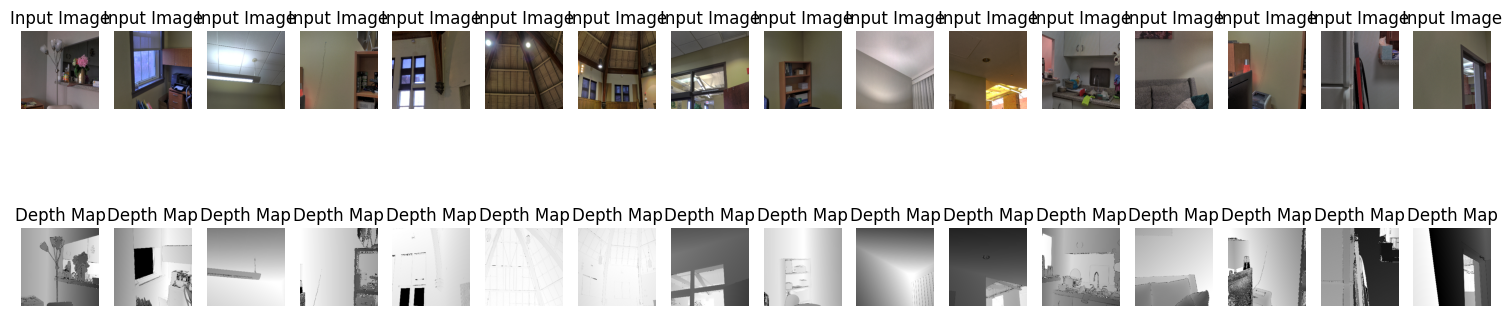

In [39]:
# visualize a batch of data
def visualize_batch(dl):
    for x, y in dl:
        x = x.permute(0, 2, 3, 1).numpy()  # Convert to [B, H, W, C] format
        y = y.squeeze().numpy()  # Remove channel dimension
        fig, axes = plt.subplots(nrows=2, ncols=len(x), figsize=(15, 5))
        for i in range(len(x)):
            axes[0, i].imshow(x[i])
            axes[0, i].set_title('Input Image')
            axes[0, i].axis('off')
            axes[1, i].imshow(y[i], cmap='gray')
            axes[1, i].set_title('Depth Map')
            axes[1, i].axis('off')
        plt.tight_layout()
        plt.show()
        break  # Show only one batch

visualize_batch(train_dl)

In [40]:
loss_func = CombinedDepthLoss(ssim_loss_weight=1.0, l1_loss_weight=1.0, edge_loss_weight=1.0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DepthEstimationModel(in_channels=3)
model = model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_dl), epochs=10)

def train_model(model, train_dl, valid_dl, optimizer, loss_func, device, epochs=10):
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_dl, optimizer, loss_func, device)
        valid_loss, metrics = validate_epoch(model, valid_dl, loss_func, device)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
        print(f"Metrics: {metrics}")

        # Update learning rate
        # scheduler.step()
        # Log to Weights & Biases
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            **metrics
        })
    return model

In [41]:
model = train_model(model, train_dl, valid_dl, optimizer, loss_func, device, epochs=10)
torch.save(model.state_dict(), 'depth_estimation_model.pth')

100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 1/10, Train Loss: 1.2364, Valid Loss: 0.8456
Metrics: {'abs_rel': tensor(0.8961, device='cuda:0'), 'log10_mae': tensor(0.3791, device='cuda:0'), 'log10_rmse': tensor(0.4196, device='cuda:0'), 'delta1': 0.07123722303658724, 'delta2': 0.15166615322232246, 'delta3': 0.27702910006046294}


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 2/10, Train Loss: 0.8216, Valid Loss: 0.8061
Metrics: {'abs_rel': tensor(1.0292, device='cuda:0'), 'log10_mae': tensor(0.2970, device='cuda:0'), 'log10_rmse': tensor(0.3562, device='cuda:0'), 'delta1': 0.1304638132452965, 'delta2': 0.2763738512992859, 'delta3': 0.4861997485160828}


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 3/10, Train Loss: 0.7101, Valid Loss: 0.6100
Metrics: {'abs_rel': tensor(1.0407, device='cuda:0'), 'log10_mae': tensor(0.2411, device='cuda:0'), 'log10_rmse': tensor(0.3097, device='cuda:0'), 'delta1': 0.16810340583324432, 'delta2': 0.3763563722372055, 'delta3': 0.7727702021598816}


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 4/10, Train Loss: 0.6396, Valid Loss: 0.5848
Metrics: {'abs_rel': tensor(1.0565, device='cuda:0'), 'log10_mae': tensor(0.2300, device='cuda:0'), 'log10_rmse': tensor(0.3045, device='cuda:0'), 'delta1': 0.19112502932548522, 'delta2': 0.4172313779592514, 'delta3': 0.7900447010993957}


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 5/10, Train Loss: 0.5921, Valid Loss: 0.8094
Metrics: {'abs_rel': tensor(1.3299, device='cuda:0'), 'log10_mae': tensor(0.2161, device='cuda:0'), 'log10_rmse': tensor(0.3056, device='cuda:0'), 'delta1': 0.30234945714473727, 'delta2': 0.5610669136047364, 'delta3': 0.8806702852249145}


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 6/10, Train Loss: 0.6002, Valid Loss: 0.5414
Metrics: {'abs_rel': tensor(1.1543, device='cuda:0'), 'log10_mae': tensor(0.2032, device='cuda:0'), 'log10_rmse': tensor(0.2950, device='cuda:0'), 'delta1': 0.2690869927406311, 'delta2': 0.6041364431381225, 'delta3': 0.8694029450416565}


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 7/10, Train Loss: 0.5670, Valid Loss: 0.5574
Metrics: {'abs_rel': tensor(1.2181, device='cuda:0'), 'log10_mae': tensor(0.1977, device='cuda:0'), 'log10_rmse': tensor(0.2948, device='cuda:0'), 'delta1': 0.2962807297706604, 'delta2': 0.6937670230865478, 'delta3': 0.8659470438957214}


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 8/10, Train Loss: 0.5376, Valid Loss: 0.5261
Metrics: {'abs_rel': tensor(1.2257, device='cuda:0'), 'log10_mae': tensor(0.1929, device='cuda:0'), 'log10_rmse': tensor(0.2935, device='cuda:0'), 'delta1': 0.30790704786777495, 'delta2': 0.7704593062400817, 'delta3': 0.8620702981948852}


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 9/10, Train Loss: 0.5673, Valid Loss: 0.5764
Metrics: {'abs_rel': tensor(1.3166, device='cuda:0'), 'log10_mae': tensor(0.1901, device='cuda:0'), 'log10_rmse': tensor(0.2982, device='cuda:0'), 'delta1': 0.33791030645370485, 'delta2': 0.814491605758667, 'delta3': 0.8551991581916809}


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

Epoch 10/10, Train Loss: 0.5344, Valid Loss: 0.4945
Metrics: {'abs_rel': tensor(1.2601, device='cuda:0'), 'log10_mae': tensor(0.1867, device='cuda:0'), 'log10_rmse': tensor(0.2936, device='cuda:0'), 'delta1': 0.3281086146831512, 'delta2': 0.8117753744125367, 'delta3': 0.8554506778717041}


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import wandb
import io
from PIL import Image  # Needed to convert from BytesIO

def visualize_predictions(model, valid_dl, device):
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            x = x.to(device)
            pred = model(x)
            pred = F.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=False)

            # Get only the first image from the batch
            pred_img = pred[0].cpu().squeeze().numpy()
            y_img = y[0].cpu().squeeze().numpy()

            # Convert to uint8 for visualization
            pred_vis = (pred_img * 255).astype(np.uint8)
            y_vis = (y_img * 255).astype(np.uint8)

            # Plot side-by-side
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].imshow(pred_vis, cmap='gray')
            axs[0].set_title('Predicted Depth')
            axs[0].axis('off')

            axs[1].imshow(y_vis, cmap='gray')
            axs[1].set_title('Ground Truth Depth')
            axs[1].axis('off')

            plt.tight_layout()

            # Save plot to buffer
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            img = Image.open(buf)

            # Log image to wandb with a caption and step
            wandb.log({
                "Prediction vs Ground Truth": wandb.Image(img, caption=f"Batch {i}")
            }, step=i)

            plt.close(fig)  # Free memory

            if i >= 4:  # Log only 5 batches
                break


In [45]:
visualize_predictions(model, valid_dl, device)